In [1]:
import string
import csv
import re
import os

from wordcloud import WordCloud
import matplotlib.pyplot as plot
import numpy as np

from collections import defaultdict

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sarahtam/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Clean csv files of actual twitter data: remove punctuation and stopwords (as defined by nltk)

def clean(name):
    
    file_in = name + '_picsremoved.csv'
    str = ''

    numrows = 0
    reader = csv.reader(open('Data/'+file_in))
    for row in reader:
        # replace http/https links with 'http'
        toAdd = re.sub(r'http\S+',r'http', row[6])
        # separate words accidentally attached to links but keep record of link
        toAdd, n = re.subn(r'\S+http',r'http.*', toAdd)
        for i in range(n):
            toAdd = toAdd + 'http'
        str = str + " " +(toAdd)
        numrows = numrows + 1
    
    sw = set(stopwords.words('english'))
    word_tokens = word_tokenize(str) 
  
    filtered = [w.lower() for w in word_tokens if w.lower() not in sw and w.isalpha()] 
            
    # return filtered list as string
    ret = (" ").join(filtered)
    return numrows, ret

In [3]:
# Cleans txt files of network-generated tweets: remove punctuation and stopwords (as defined by nltk)

def clean_txt(name, folder):
    str = ''
    
    if folder == 'Generated tweets GPT-2/':
        file_name = folder + name;
    else:
        file_name = folder + name + '_generated_tweets.txt'
        
    f = open(file_name, "r") 
    numrows = 0
    
    for line in f:
        if line[0] != '=':
            # replace http/https links with 'http'
            toAdd = re.sub(r'http\S+',r'http', line)
            # separate words accidentally attached to links but keep record of link
            toAdd, n = re.subn(r'\S+http\S+',r'http.*', toAdd)
            for i in range(n):
                toAdd = toAdd + 'http'
            str = str + " " + toAdd
            numrows = numrows + 1

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(str) 
    filtered = [w.lower() for w in word_tokens if not w.lower() in stop_words and w.isalpha()] 
    
    ret = (" ").join(filtered)
    return numrows, ret

In [4]:
# returns defaultdictw where key=words and values=frequency
def word_count(words):
    counts = defaultdict(int)

    for word in words:
        counts[word] += 1

    return counts

In [29]:
# Visualizations of word frequency: print bar graphs of top ten most frequent words, word clouds
# Returns average words per tweet

def word_frequency(name, filetype, col):
    if filetype == "gan_txt":
        numtweets, person = clean_txt(name.lower(), 'Generated tweets GPT-2/')
        name = re.sub('_.*','',name).capitalize()
    elif filetype == 'lstm_txt':
        numtweets, person = clean_txt(name.lower(),'LSTM-Generated/')
        name = re.sub('_.*','',name).capitalize()
    else:
        numtweets, person = clean(name.lower())
        
    if name == 'Aoc':
        name = 'AOC'
    
    words = person.split()
    avg_words_per_tweet = len(words) / numtweets
    
    d = word_count(words)
    
    # print top ten words
    topten = sorted(d.items(), key=lambda v: v[1], reverse=True)[:11]
    topten_keys = ['\"' + k[0] + '\"' for k in topten] 
    topten_values = [v[1] for v in topten] 
#     plot.figure(figsize=(4,4)) 
#     plot.barh(topten_keys, topten_values, color=col)
#     plot.title(name, fontsize=14)
#     plot.xlabel('Word Frequency')
#     plot.xticks(rotation=45)
#     plot.gca().invert_yaxis()
# #     plot.savefig(name+'_freq.png',bbox_inches = "tight")
#     plot.show()
    
#   histogram of word counts - decidec not to use
#     logbins = np.geomspace(min(d.values()), max(d.values()), 15)
#     plot.hist(d.values(), bins=logbins)
    
#     plot.ylabel('Number of Words')
#     plot.xscale('log')
#     plot.xlabel('Word Count');
#     plot.title(name + " Word Frequency")
#     plot.show() 

    p = re.sub('http','',person)
    p = re.sub('https','',p)

    # word cloud
#     cloud = WordCloud(width = 500, height = 400, 
#                       background_color ='white', 
#                       min_font_size = 10, collocations=False).generate(p)
#     plot.imshow(cloud) 
#     plot.axis("off") 
#     plot.title(name,fontsize=14)
#     plot.savefig(name+'_cloud.png')
#     plot.show() 

    print(topten_keys)
    
    return avg_words_per_tweet

In [6]:
# Sentiment analysis for csv files
def sentiment(name, sid_obj,col):
    
    file_in = name + '_picsremoved.csv'
    
    pos=[]
    neu=[]
    neg=[]
    cmp=[]

    reader = csv.reader(open('Data/'+file_in))
    for row in reader:
        text = row[6]
        sentiment = sid_obj.polarity_scores(text) 
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
        cmp.append(sentiment['compound'])
        
#     plot.hist(pos)
#     plot.hist(neu)
#     plot.hist(neg)
    plot.figure(figsize=(4,4)) 
    plot.xlabel('Sentiment Score')
    plot.hist(cmp,color=col)
    plot.title(name,fontsize=14)
    
    avg = sum(cmp) / len(cmp)
    
#     plot.savefig(name+'_sent.png')
    plot.show()
    
    return avg, list(cmp)

In [35]:
# Sentiment analysis for txt files

def sentiment_txt(name, net, sid_obj, col):

    pos=[]
    neu=[]
    neg=[]
    cmp=[]
    
    if net == 'lstm':
        file_name = 'LSTM-Generated/' + name + '_generated_tweets.txt'
        name = re.sub('_.*','',name).capitalize()
        file_out = name+'_lsent.png'
    else:
        file_name = 'Generated tweets GPT-2/' + name
        name = re.sub('_.*','',name).capitalize()
        file_out = name+'_gsent.png'
        
    f = open(file_name, "r") 
    
    for text in f:
        sentiment = sid_obj.polarity_scores(text) 
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
        cmp.append(sentiment['compound'])
        
    avg = sum(cmp) / len(cmp)
        
#     plot.hist(pos)
#     plot.hist(neu)
#     plot.hist(neg)
    plot.figure(figsize=(4,4)) 
    plot.hist(cmp,color=col)
    plot.xlabel('Sentiment Score')
    if net == 'lstm':
        plot.title(name + " (LSTM)",fontsize=14)
    else:
        plot.title(name + " (GPT-2)",fontsize=14)
    
    plot.savefig(file_out)
    plot.show()
    
    return avg

138435


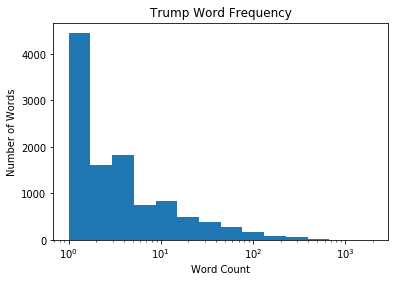

137975


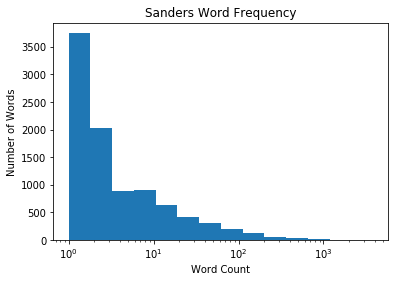

133624


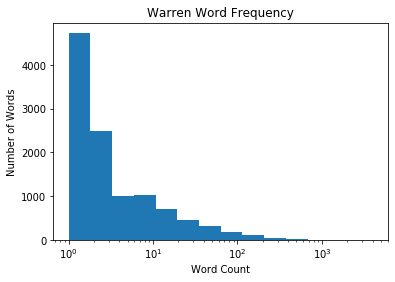

103197


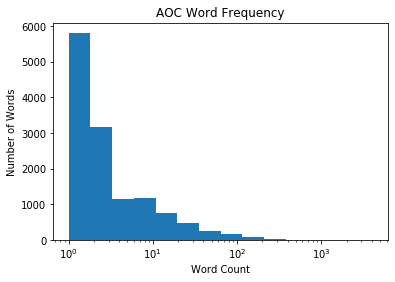

33280


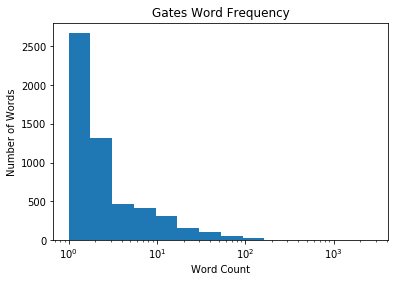

48019


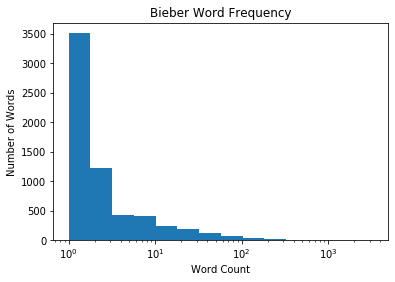

47741


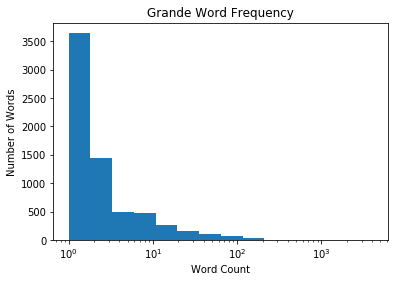

77307


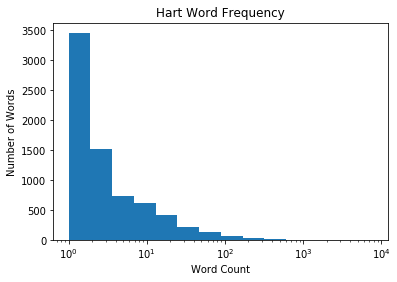

46638


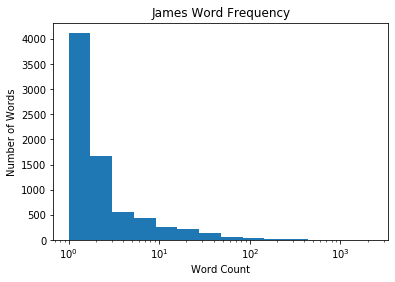

96136


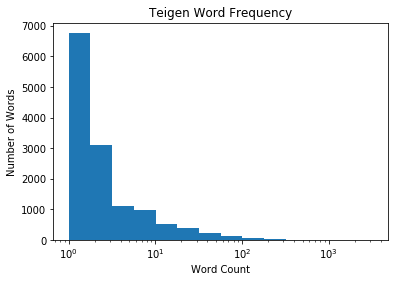

In [9]:
# Actual tweets (training data): visualize word frequency

political = ['Trump','Sanders','Warren','AOC','Gates']
entertainers = ['Bieber','Grande','Hart','James','Teigen']
pol_wpt = []
ent_wpt = []
col1 = (0.2,0.5,0.8,1.0) # political figures
col2 = (0.2,0.6,0.6,1.0) # entertainers
for person in political:
    pol_wpt.append(word_frequency(person,'csv',col1))
for person in entertainers:
    ent_wpt.append(word_frequency(person,'csv',col2))

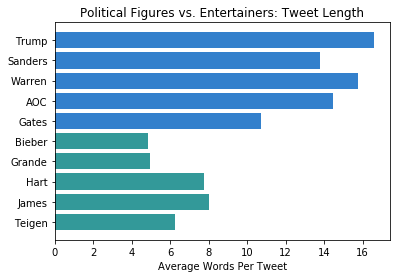

In [27]:
# Average words per tweet for training data
plot.barh(political+entertainers, pol_wpt+ent_wpt, color=[col1,col1,col1,col1,col1,col2,col2,col2,col2,col2])
plot.title('Political Figures vs. Entertainers: Tweet Length',fontsize=12)
plot.xlabel('Average Words Per Tweet')
plot.gca().invert_yaxis()
plot.savefig('raw_wpt.png')
plot.show()

In [10]:
# Sentiment of training data

sid_obj = SentimentIntensityAnalyzer() 

pol_sent = []
ent_sent = []
all_sents = []

for person in political:
    sent,data = sentiment(person, sid_obj, col1)
    pol_sent.append(sent)
    all_sents.append(data)
for person in entertainers:
    sent,data = sentiment(person, sid_obj, col2)
    ent_sent.append(sent)
    all_sents.append(data)

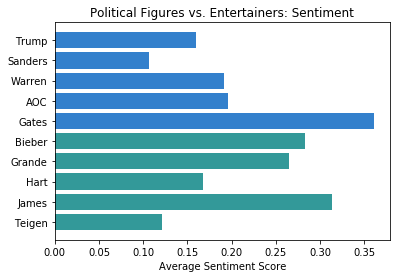

In [38]:
# Bar plot comparing sentiment of political and entertainers (training data)
plot.barh(political+entertainers, pol_sent+ent_sent, color=[col1,col1,col1,col1,col1,col2,col2,col2,col2,col2])
plot.title('Political Figures vs. Entertainers: Sentiment',fontsize=12)
plot.xlabel('Average Sentiment Score')
plot.gca().invert_yaxis()
# plot.savefig('raw_sent.png')
plot.show()

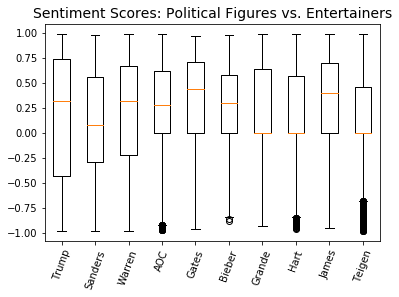

In [24]:
# Boxplot comparing sentiment of political and entertainers (training data)

combined= political + entertainers
    
plot.boxplot(all_sents)
plot.title("Sentiment Scores: Political Figures vs. Entertainers", fontsize=14)
plot.xticks([1,2,3,4,5,6,7,8,9,10],combined, rotation=70)
# plot.savefig("sentiment_boxplot.png", bbox_inches = "tight")
plot.show()

28990


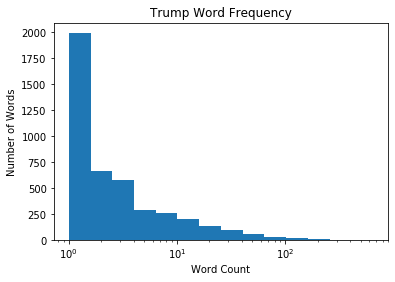

30552


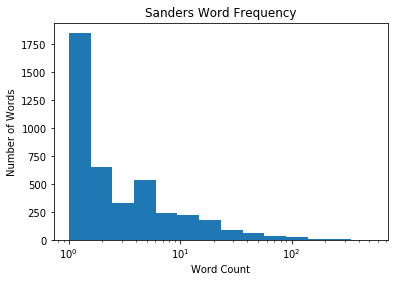

37590


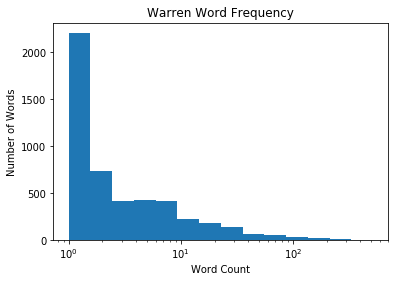

18044


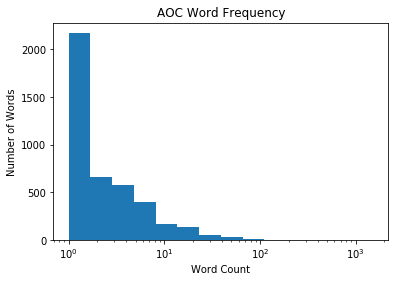

22828


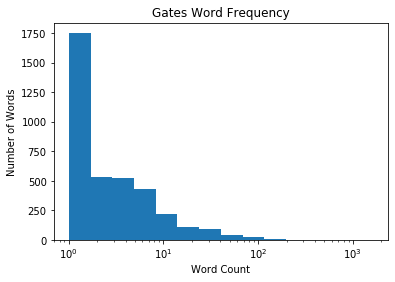

12038


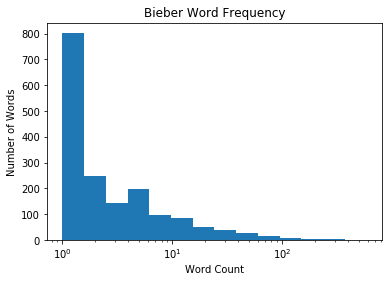

7341


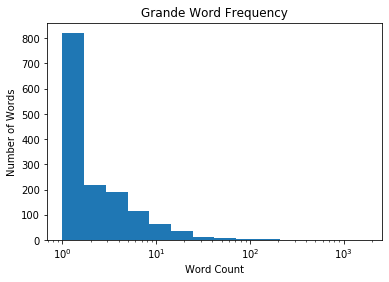

12671


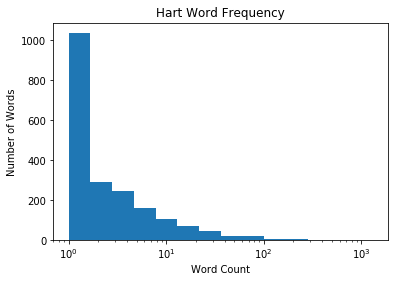

12108


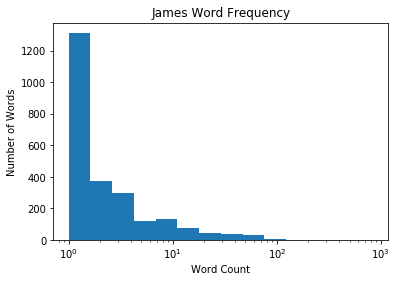

16781


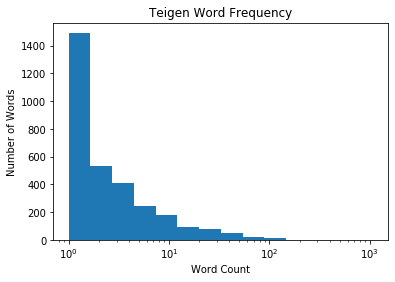

In [11]:
# GPT-2 generated tweets: visualize word frequency

col1 = (0.2,0.5,0.8,1.0) # political figures
col2 = (0.2,0.6,0.6,1.0) # entertainers

pol_generated = ['trump_gpt2_gentext_20200422_114633.txt',
                 'sanders_gpt2_gentext_20200422_132841.txt', 
                 'warren_gpt2_gentext_20200423_195923.txt',
                 'aoc_gpt2_gentext_20200424_103305.txt',
                 'gates_gpt2_gentext_20200422_144757.txt']
ent_generated = ['bieber_gpt2_gentext_20200422_143655.txt',
                 'grande_gpt2_gentext_20200423_172156.txt',
                 'hart_gpt2_gentext_20200423_145030.txt',
                 'james_gpt2_gentext_20200424_130853.txt',
                 'teigen_gpt2_gentext_20200424_125356.txt']
polg_wpt = []
entg_wpt = []
for g in pol_generated:
    polg_wpt.append(word_frequency(g,'gan_txt',col1))
for g in ent_generated:
    entg_wpt.append(word_frequency(g,'gan_txt',col2))

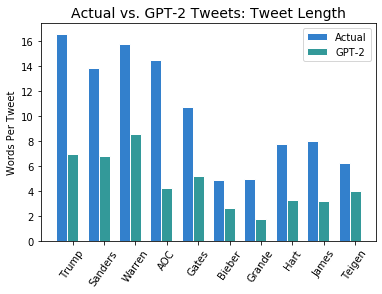

In [28]:
# Comparing words per tweet: actual tweets vs. GPT-2 generated tweets

barWidth = 0.35
bars1 = pol_wpt + ent_wpt
bars2 = polg_wpt + entg_wpt

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plot.bar(r1, bars1, color=col1, width=barWidth, edgecolor='white', label='Actual')
plot.bar(r2, bars2, color=col2, width=barWidth, edgecolor='white', label='GPT-2')

plot.title('Actual vs. GPT-2 Tweets: Tweet Length', fontsize=14)
plot.xticks([r + barWidth for r in range(len(bars1))], political + entertainers, rotation=55)
plot.ylabel('Words Per Tweet')

plot.legend()
# plot.savefig('compared_wpt.png')
plot.show()

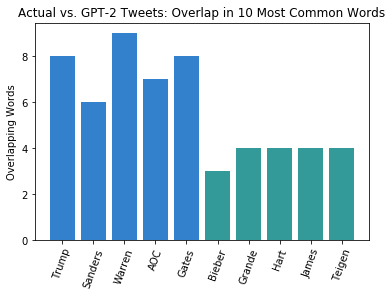

In [30]:
# Bar graph of number of top ten words that match between actual tweets and GPT-2 tweets
matched_terms = [8,6,9,7,8,3,4,4,4,4]
plot.bar(political+entertainers, matched_terms, color=[col1,col1,col1,col1,col1,col2,col2,col2,col2,col2])
plot.title('Actual vs. GPT-2 Tweets: Overlap in 10 Most Common Words',fontsize=12)
plot.ylabel('Overlapping Words')
plot.xticks(rotation=70)
plot.savefig('toptenmatch.png')
plot.show()

In [12]:
sid_obj = SentimentIntensityAnalyzer() 

pol_gsent = []
ent_gsent = []

for g in pol_generated:
    pol_gsent.append(sentiment_txt(g, 'gan',sid_obj, col1))
for g in ent_generated:
    ent_gsent.append(sentiment_txt(g, 'gan',sid_obj, col2))

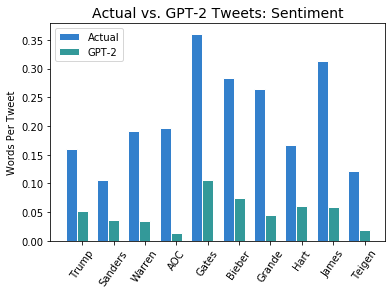

In [25]:
# Comparing sentiment: actual tweets vs. GPT-2 generated tweets

barWidth = 0.35
bars1 = pol_sent + ent_sent
bars2 = pol_gsent + ent_gsent

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plot.bar(r1, bars1, color=col1, width=barWidth, edgecolor='white', label='Actual')
plot.bar(r2, bars2, color=col2, width=barWidth, edgecolor='white', label='GPT-2')

plot.title('Actual vs. GPT-2 Tweets: Sentiment', fontsize=14)
plot.xticks([r + barWidth for r in range(len(bars1))], political + entertainers, rotation=55)
plot.ylabel('Words Per Tweet')

plot.legend()
# plot.savefig('compared_sent.png', bbox_inches = "tight")
plot.show()

In [30]:
# LSTM-generated tweets: visualize word frequency

col1 = (0.2,0.5,0.8,1.0)

lstm_people = ['bieber', 'hart', 'gates','sanders']

lstm_wpt = []
for g in lstm_people:
    lstm_wpt.append(word_frequency(g,'lstm_txt',col1))

['"http"', '"u"', '"get"', '"love"', '"beliebers"', '"show"', '"help"', '"got"', '"itunes"', '"skrillex"', '"shots"']
['"http"', '"movie"', '"shit"', '"man"', '"rt"', '"movies"', '"get"', '"wedding"', '"ca"', '"new"', '"ringer"']
['"http"', '"world"', '"great"', '"progress"', '"see"', '"fight"', '"people"', '"one"', '"way"', '"lives"', '"ever"']
['"http"', '"bernie"', '"vermont"', '"sanders"', '"people"', '"country"', '"vt"', '"ows"', '"care"', '"american"', '"health"']


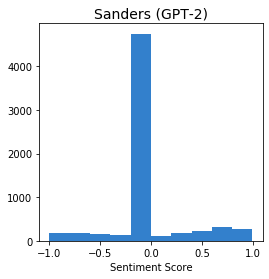

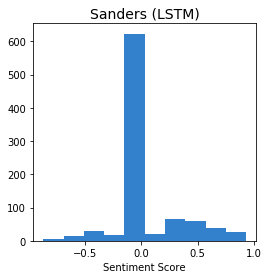

0.07985868596881955

In [37]:
sid_obj = SentimentIntensityAnalyzer() 

sentiment_txt('sanders_gpt2_gentext_20200422_132841.txt', 'gpt2',sid_obj, col1)
sentiment_txt('Sanders', 'lstm',sid_obj, col1)

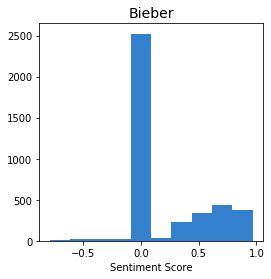

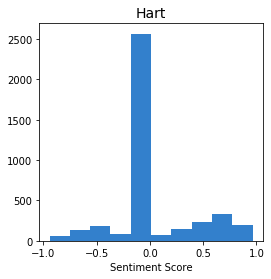

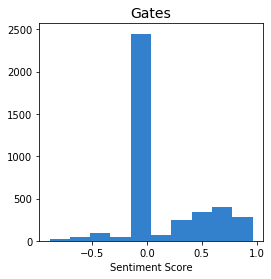

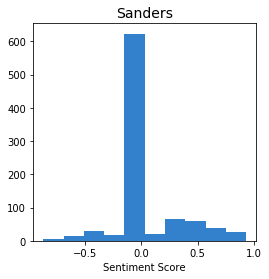

In [28]:
# Sentiment of LSTM-generated tweets

sid_obj = SentimentIntensityAnalyzer() 

lstm_sent = []

for g in lstm_people:
    lstm_sent.append(sentiment_txt(g, 'lstm',sid_obj, col1))

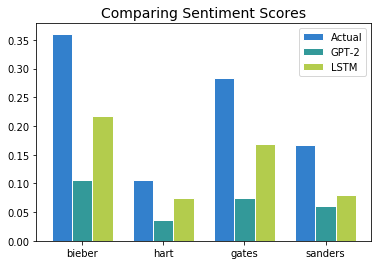

In [40]:
# Comparing sentiment: actual tweets vs. GPT-2 vs. LSTM

col1 = (0.2,0.5,0.8,1.0) 
col2 = (0.2,0.6,0.6,1.0) 
col3 = (0.7,0.8,0.3,1.0)

barWidth = 0.25
b1 = [pol_sent[4], pol_sent[1], ent_sent[0], ent_sent[2]]
b2 = [pol_gsent[4], pol_gsent[1], ent_gsent[0], ent_gsent[2]]
b3 = lstm_sent

r1 = np.arange(len(b1))
r2 = [x + barWidth for x in r1]
r3 =[x + barWidth for x in r2]

plot.bar(r1, b1, color=col1, width=barWidth, edgecolor='white', label='Actual')
plot.bar(r2, b2, color=col2, width=barWidth, edgecolor='white', label='GPT-2')
plot.bar(r3, b3, color=col3, width=barWidth, edgecolor='white', label='LSTM')

plot.title('Comparing Sentiment Scores', fontsize=14)
plot.xticks([r + barWidth for r in range(len(b1))], lstm_people)

plot.legend()
# plot.savefig('sentiment_all.png')
plot.show()

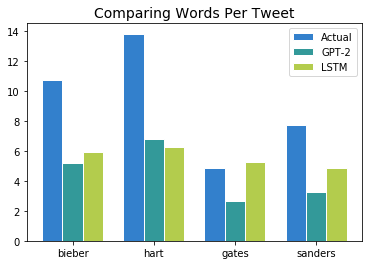

In [41]:
# Comparing words per tweet: actual tweets vs. GPT-2 vs. LSTM

barWidth = 0.25
b1 = [pol_wpt[4], pol_wpt[1], ent_wpt[0], ent_wpt[2]]
b2 = [polg_wpt[4], polg_wpt[1], entg_wpt[0], entg_wpt[2]]
b3 = lstm_wpt

r1 = np.arange(len(b1))
r2 = [x + barWidth for x in r1]
r3 =[x + barWidth for x in r2]

plot.bar(r1, b1, color=col1, width=barWidth, edgecolor='white', label='Actual')
plot.bar(r2, b2, color=col2, width=barWidth, edgecolor='white', label='GPT-2')
plot.bar(r3, b3, color=col3, width=barWidth, edgecolor='white', label='LSTM')

plot.title('Comparing Words Per Tweet', fontsize=14)
plot.xticks([r + barWidth for r in range(len(b1))], lstm_people)

plot.legend()
# plot.savefig('wpt_all.png')
plot.show()